# 1. Install Dependencies and Setup

- tensorflow
- opencv-python
- matplotlib
- `download all images` chrome extension

In [1]:
import tensorflow as tf
import os
import cv2 
import imghdr # to check image type
import numpy as np
import matplotlib.pyplot as plt

# build deep learning model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
model = Sequential()

# evaluate model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

# save model
from tensorflow.keras.models import load_model

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [3]:
data_dir = "data" # replace with the path to your directory
image_exts = ['jpeg','jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path) # to check if image can be read
            tip = imghdr.what(image_path) # to check if match image_exts format
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
                
            elif os.path.getsize(image_path) < 10240: # check if image size is less than 10 KB
                print('Image too small {}'.format(image_path))
                os.remove(image_path)
                
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [4]:
data = tf.keras.preprocessing.image_dataset_from_directory('data')
batch = data.as_numpy_iterator().next() # convert to numpy array & get first batch
# [0] is the images, [1] is labels : 1 is sad, 0 is happy

Found 166 files belonging to 2 classes.


In [5]:
def displayImage(image):
    # display image
    fig, ax = plt.subplots(ncols=4, figsize=(20,20))
    for idx, img in enumerate(image[0][:4]):
        ax[idx].imshow(img.astype(int))
        ax[idx].title.set_text(image[1][idx])

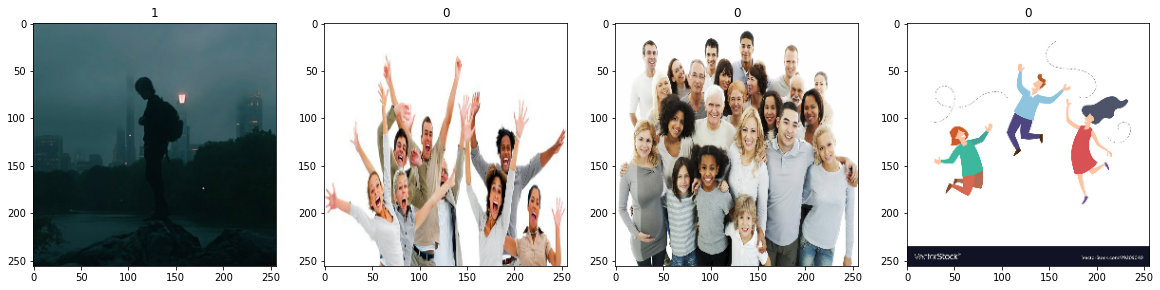

In [6]:
displayImage(batch)

# 4. Scale Data

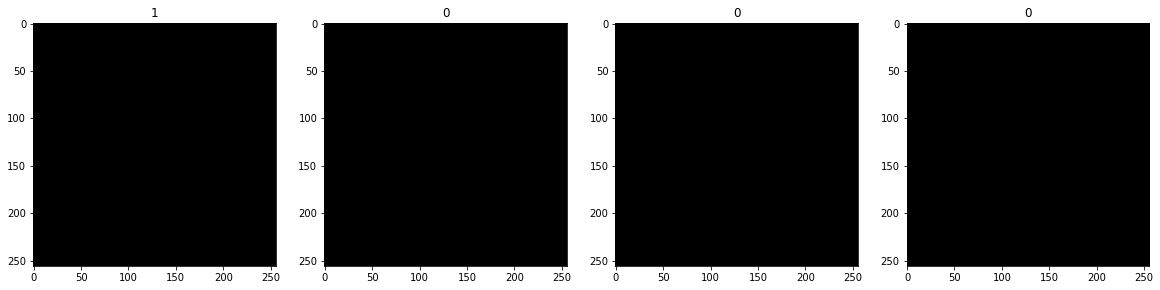

In [7]:
data = data.map(lambda x,y: (x/255, y))
scaled_iterator = data.as_numpy_iterator().next()  # shuffling/randomize the data

displayImage(scaled_iterator)

# 5. Split Data

In [8]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = len(data) - train_size - val_size

train = data.take(train_size) # take() returns the first n elements of the dataset
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

print(len(train))
print(len(val))
print(len(test))

4
1
1


# 6. Build Deep Learning Model

In [10]:
# 3 layers of Conv2D and MaxPooling2D
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

# usually for binary classification
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [11]:
# like tuning
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [12]:
logdir='logs'

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
4/4 [==============================] - 5s 912ms/step - loss: 0.7723 - accuracy: 0.5781 - val_loss: 0.7497 - val_accuracy: 0.4688
Epoch 2/20
4/4 [==============================] - 4s 897ms/step - loss: 0.6774 - accuracy: 0.5859 - val_loss: 0.5567 - val_accuracy: 0.6250
Epoch 3/20
4/4 [==============================] - 5s 976ms/step - loss: 0.5889 - accuracy: 0.6172 - val_loss: 0.5572 - val_accuracy: 0.6250
Epoch 4/20
4/4 [==============================] - 4s 917ms/step - loss: 0.5659 - accuracy: 0.7109 - val_loss: 0.4829 - val_accuracy: 0.7500
Epoch 5/20
4/4 [==============================] - 4s 896ms/step - loss: 0.4878 - accuracy: 0.7344 - val_loss: 0.5520 - val_accuracy: 0.7188
Epoch 6/20
4/4 [==============================] - 5s 943ms/step - loss: 0.4467 - accuracy: 0.7891 - val_loss: 0.3738 - val_accuracy: 0.7812
Epoch 7/20
4/4 [==============================] - 5s 967ms/step - loss: 0.3775 - accuracy: 0.8281 - val_loss: 0.2903 - val_accuracy: 0.9688
Epoch 8/20
4/4 [====

# 8. Plot Performance

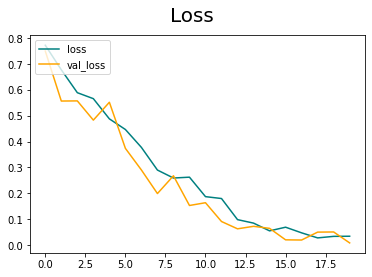

In [13]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

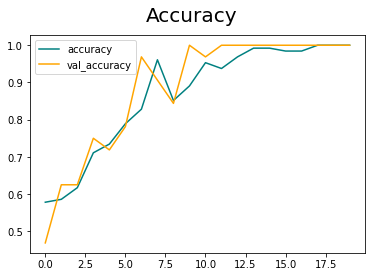

In [14]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [15]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    
print(f'Precision:{pre.result()}, Recall:{re.result()}, Accuracy: {acc.result()}')

1/1 [==============================] - 0s 100ms/step
Precision:1.0, Recall:1.0, Accuracy: 1.0


# 10. Test

In [62]:
img = cv2.imread('testing/happy1.jpg')
resize = tf.image.resize(img, (256,256))

yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat[0][0])

if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

1/1 [==============================] - 0s 28ms/step
0.9702297


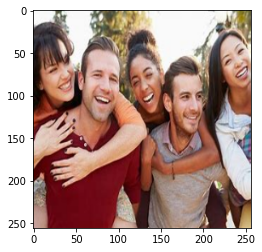

In [54]:
# show image
plt.imshow(cv2.cvtColor(resize.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.show()

# 11. Save the Model

In [19]:
# save in models folder
model.save('models/imageclassifier.h5')

c:\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 12. Use the Model

In [ ]:
# specify image
img = cv2.imread('testing/happy1.jpg')
resize = tf.image.resize(img, (256,256))

# load model
new_model = load_model('models/imageclassifier.h5')
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

# predict
yhat = model.predict(np.expand_dims(resize/255, 0))
print(yhat[0][0])

if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')